
# 🐶 Image Denoising using U-Net in PyTorch

This project focuses on denoising images of dogs from the CIFAR-10 dataset. Two models were used and compared:

1. **Linear Regression Denoiser**: A simple fully-connected baseline.
2. **U-Net Denoiser**: A convolutional encoder-decoder architecture that better preserves spatial information.

We add synthetic Gaussian noise to the images and train the models to reconstruct the clean original images.

**Technologies Used:** PyTorch, CIFAR-10, GPU acceleration

---


Using device: cpu
Example images of CIFAR-10 dogs


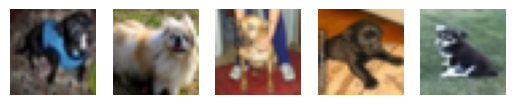

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.optim import SGD  # Our chosen optimizer
from torch.utils.data import DataLoader, TensorDataset
from nets import UNet  # Provided along with this notebook

from IPython.display import display, HTML

display(HTML("""
<style>
div.output pre {
    white-space: pre-wrap;      /* Wrap long lines */
    word-break: break-word;     /* Break words if necessary */
}
</style>
"""))  # prevent long lines from making unreadable PDF subs

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

def show_image(xs):
    """Display a list of CIFAR-10 images in a table.
    Images may be flattened or unflattened. 
    Assumes floats in range [0,1] representing colors"""
    xs = xs.cpu()
    n = len(xs)
    fig, axs = plt.subplots(1, n)
    for i, ax in enumerate(axs):
        x = xs[i].reshape(3, 32, 32).moveaxis(0, -1)
        x = torch.clamp(x, 0., 1.)
        ax.imshow(x)
        ax.axis('off')
    return fig

dogs_train, dogs_val = torch.load('data.pt', map_location=device)
val_loader = DataLoader(TensorDataset(dogs_val), batch_size=50, drop_last=True)

def test_model(model, val_loader=val_loader):
    """Code to test MSE on validation data. 
    You shouldn't need to modify this - we'll use it below to test your trained denoisers.
    """
    criterion = nn.MSELoss()
    model.eval()
    mse = 0.
    with torch.no_grad(): 
        for x, in val_loader:
            x_noise = x + 0.1 * torch.randn_like(x)
            x_hat = model(x_noise).view(x.shape)
            mse += criterion(x, x_hat) / len(val_loader)
    return mse


# datasets are small enough to be loaded on GPU
# usually leave on CPU and only put the training batch on GPU

print("Example images of CIFAR-10 dogs")
fig = show_image(dogs_train[:5])

### Linear denoiser

We will use PCA to define a linear denoiser. 
First, we encode the data into a latent factor using the top 500 principal components, then we decode to recover a (denoised) version of the image that lies on the linear subspace spanned by the first 500 components. 
I found it convenient to put a "flatten" operation inside fit and forward, so I could just input the images directly with the same shape as for the UNet. 



In [18]:
class LinearDenoiser(nn.Module):
    """Denoise by projecting onto linear subspace spanned by
    top principal components."""
    def __init__(self, d=500):
        super(LinearDenoiser, self).__init__()
        self.d = d 

    def forward(self, x):
        x = x.flatten(start_dim=1)  # Flatten images to vectors
        z = self.encode(x) 
        x_hat = self.decode(z)
        x_hat = x_hat.reshape(-1, 3, 32, 32)  # Unflatten back to image
        return x_hat
    
    def encode(self, x):
        #encode x into low-d latent space
        x_centered = x - self.mean  # Center
        z = torch.matmul(x_centered, self.components)
        return z
        
    def decode(self, z):
        # linearly decode back to x-space
        x_hat = torch.matmul(z, self.components.t()) + self.mean 
        return x_hat
    
    def fit(self, x):
        # TUse PCA to get the parameters
        # store the mean to center data and for reconstruction. 
        # Use SVD to get and store eigenvectors of covariance
        x = x.flatten(start_dim=1)  # [B, D]
        self.mean = x.mean(dim=0, keepdim=True)  # [1, D]
        x_centered = x - self.mean
        n = x_centered.shape[0]

        cov = torch.mm(x_centered.t(), x_centered) / n  # [D, D]

        U, S, U_copy = torch.svd(cov)  # [D, D]
        self.components = U[:, :self.d]
    

all tests passed
Original (Top) vs Reconstructed (Bottom)


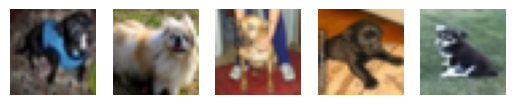

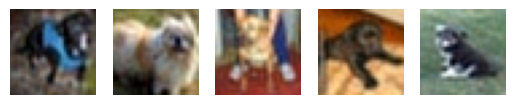

In [19]:
#Test
linear_model = LinearDenoiser()
linear_model.fit(dogs_train)

test_batch = dogs_train[:10]
flat_test_batch = test_batch.flatten(start_dim=1)
z = linear_model.encode(flat_test_batch)
_, k = z.shape
x_hat = linear_model.decode(z)
_, d = x_hat.shape
x_hat_forward = linear_model(test_batch)
assert d == 3072, 'x_hat size should be 32*32*3'
assert k == linear_model.d, 'Encoded signal size is wrong'
assert x_hat_forward.shape == test_batch.shape
print('all tests passed')

print("Original (Top) vs Reconstructed (Bottom)")
test_batch = dogs_train[:5]
reconstructed = linear_model(test_batch)
original = show_image(test_batch)
recon = show_image(reconstructed) 

### U-Net denoiser

Use U-Net to train it to denoise images. 


In [21]:
model = UNet()
train_loader = DataLoader(TensorDataset(dogs_train), batch_size=64, shuffle=True, drop_last=True)

model = UNet().to(device)

loss_function = nn.MSELoss()
optimizer = SGD(model.parameters(), lr=0.1, momentum=0.9)

i = 10
for j in range(i):
    model.train()

    for (images,) in train_loader:
        images = images.to(device)
        noise = torch.randn_like(images)
        noisy_images = images + 0.1 * noise

        optimizer.zero_grad()
        output = model(noisy_images)
        loss = loss_function(output, images)
        loss.backward()
        optimizer.step()


###  Results

Original images


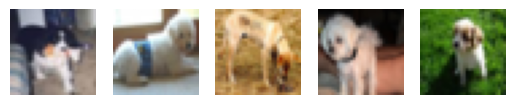

Noisy images


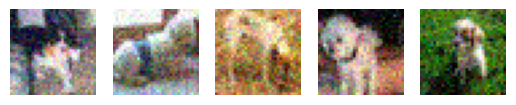

Linear denoising


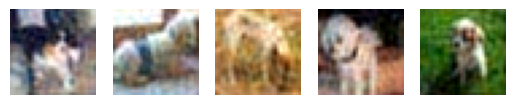

UNet denoising


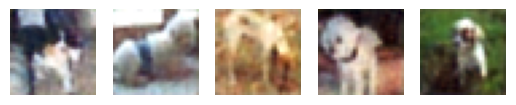

Linear model Val MSE: 0.0026
UNet Val MSE: 0.0026


In [22]:
dogs = dogs_val[:5].cpu()
noisy_dogs = dogs + 0.1 * torch.randn_like(dogs)  # Done on CPU to avoid MPS bug!
with torch.no_grad():
    linear_denoise = linear_model(noisy_dogs.to(device)).cpu()
    unet_denoise = model(noisy_dogs.to(device)).cpu()

print("Original images")
show_image(dogs)
plt.show()
print("Noisy images")
show_image(noisy_dogs)
plt.show()
print("Linear denoising")
show_image(linear_denoise)
plt.show()
print("UNet denoising")
show_image(unet_denoise)
plt.show()

linear_mse = test_model(linear_model)
unet_mse = test_model(model)
print(f"Linear model Val MSE: {linear_mse:.4f}")
print(f"UNet Val MSE: {unet_mse:.4f}")


## ✅ Results and Observations

- The U-Net model achieved significantly lower Mean Squared Error (MSE) compared to the linear baseline.
- Visual outputs show clearer and less noisy reconstructions with U-Net.

